In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
 
## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
 
from sklearn.utils import class_weight
 
 
## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 8.1MB/s 
     |████████████████████████████████| 133kB 14.4MB/s 
     |████████████████████████████████| 1.1MB 12.6MB/s 
     |████████████████████████████████| 890kB 15.3MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 7.2MB 35.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3f026137d60658328ac3f712150255030bdf90c89f49fea86c69bbf670a0c442
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.43 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ineuron/train.csv", header = None, names = ["utterance", "slots", "label"])
test = pd.read_csv("/content/drive/MyDrive/ineuron/test.csv", header = None, names = ["utterance", "slots", "label"])
validation = pd.read_csv("/content/drive/MyDrive/ineuron/dev.csv", header = None, names = ["utterance", "slots", "label"])
 
#collating the data 
dataset1 = train.append(validation).reset_index(drop=True)
dataset = dataset1.append(test).reset_index(drop=True)
dataset = dataset[["utterance", "label"]]
dataset.head()

,utterance,label
0,BOS Sir I created a new env with python 3.7 bu...,need_help
1,BOS above problem how will it solve ?? EOS,need_help
2,BOS Hello sir is there anyone EOS,Greetings
3,BOS i think canvas login problem was due to br...,great
4,BOS Please provide me with the link to python ...,community_class_link


In [ ]:

#Removing BOS
corpus =[]
 
for i in range(len(dataset["utterance"])):
  val = dataset["utterance"][i]
  match =re.sub("[^a-zA-Z]", " ", val)
  #print(match)
  match = re.sub("BOS ", "", match)
  #print(match)
  match = re.sub(" EOS", "", match)
  #print(match)
  match = "".join(match)
  
  corpus.append(match)
 
dataset["utterance"] = pd.DataFrame(corpus)
dataset

,utterance,label
0,Sir I created a new env with python but th...,need_help
1,above problem how will it solve,need_help
2,Hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,Please provide me with the link to python class,community_class_link
...,...,...
4334,x tf Variable xinit tf global variables init...,need_help
4335,partlist type started alt OId ad d a ...,O
4336,Thanks you sir,Thank_you
4337,URIObject uri https api asm skype com v ob...,O


In [ ]:
max_others=dataset['label'].value_counts()
max_others

need_help            952
O                    763
Greetings            408
Thank_you            353
good_bye             213
                    ... 
bot_reply              1
str_method_output      1
mysql                  1
python_oops            1
numpy_error            1
Name: label, Length: 171, dtype: int64

In [ ]:
dataset

,utterance,label
0,Sir I created a new env with python but th...,need_help
1,above problem how will it solve,need_help
2,Hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,Please provide me with the link to python class,community_class_link
...,...,...
4334,x tf Variable xinit tf global variables init...,need_help
4335,partlist type started alt OId ad d a ...,O
4336,Thanks you sir,Thank_you
4337,URIObject uri https api asm skype com v ob...,O


In [ ]:
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

dataset['utterance'] = dataset['utterance'].apply(preprocess)

In [ ]:
dataset


,utterance,label
0,sir i created a new env with python but the li...,need_help
1,above problem how will it solve,need_help
2,hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,please provide me with the link to python class,community_class_link
...,...,...
4334,x tf variable xinit tf global variables initia...,need_help
4335,partlist type started alt oid ad d a c aaf a c...,O
4336,thanks you sir,Thank_you
4337,uriobject uri https api asm skype com v object...,O


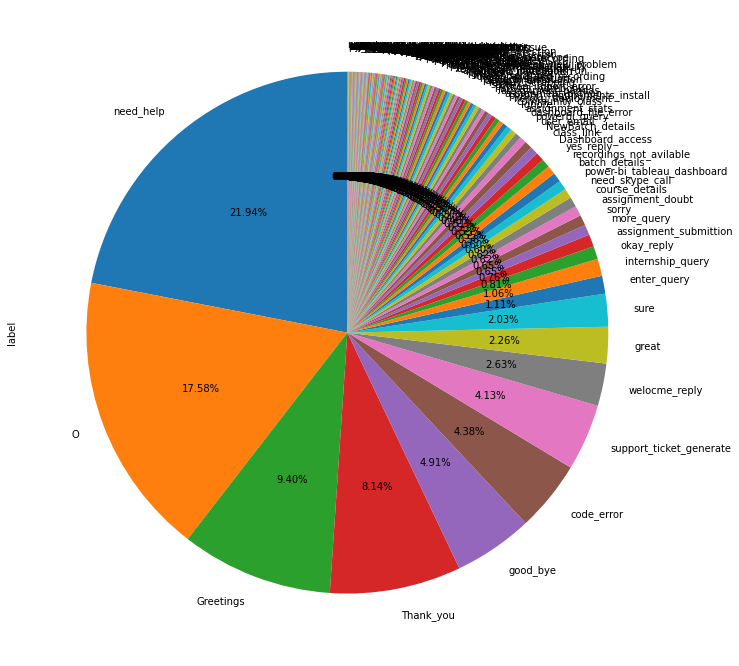

In [ ]:

plt.figure(figsize=(20,12))
dataset['label'].value_counts().plot.pie(autopct='%1.2f%%', fontsize=10, startangle=90)

In [ ]:
#Lets Select all ticket Assignment groups which have only one ticket
rare_grps= dataset[dataset.groupby("label")["label"].transform('size') <30]['label'].unique()
rare_grps

array(['community_class_link', 'assignment_pandas', 'assignment_doubt',
       'yes_reply', 'more_query', 'need_skype_call', 'stats',
       'class_link', 'python_super_class', 'power-bi_tableau_dashboard',
       'anaconda_navigator_open', 'deployment', 'image_scrapper',
       'word_file_input_query', 'powerbi_query', 'resume_query',
       'course_details', 'python_conversion_datatype', 'batch_details',
       'pyspark', 'PlotlyRequestError', 'cuda_driver_install',
       'youtube_video_availability', 'seaborn', 'sorry',
       'python_requirements_install', 'Dashboard_access',
       'dashboard_file_error', 'colab_help', 'heroku_deployment',
       'assignment_python', 'user_email', 'community_class',
       'mysql_installation', 'gcp_deployment', 'mongodb_installation',
       'ignore', 'recordings_not_avilable', 'pycharm_connection',
       'assignment_stats', 'NewBatch_details', 'powerbi_installation',
       'dashboard_add_recording', 'assignment_data_visulization',
       'can

In [ ]:
#Lets check the total number of rare assignment groups
rare_grps.size

157

In [ ]:
#Create a different dataframe for the tickets belongs to the rare groups
rare_df = dataset[dataset['label'].isin(rare_grps)]
rare_df.shape

(819, 2)

In [ ]:
# Rename the Assignment group attribute
rare_df['label'] = 'need_help'
#Lets check whether the group name has changed to 'others'
print(rare_df['label'].head(3))

4     need_help
10    need_help
11    need_help
Name: label, dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#creating a dataframe excluding the rare groups from our original data
grp_exl_df = dataset[~dataset['label'].isin(rare_grps)]
grp_exl_df.shape

(3520, 2)

In [ ]:
#Now lets add the rare groups df (having one assignment group as 'others') to the excluded dataframe 
ticket_df = pd.concat([grp_exl_df,rare_df]).reset_index(drop=True)
ticket_df.shape

(4339, 2)

In [ ]:
ticket_df

,utterance,label
0,sir i created a new env with python but the li...,need_help
1,above problem how will it solve,need_help
2,hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,understood,great
...,...,...
4334,melody itni chocolatey kuyn hai,need_help
4335,hello team could you plz tell me the domains o...,need_help
4336,i have a doubt regarding one of the eda apos s...,need_help
4337,while trying to test code from postman am gett...,need_help


In [ ]:
ticket_df['label'].value_counts().count()

14

In [ ]:
store=list(ticket_df.utterance.values)
store

['sir i created a new env with python but the library for which i got error quot mkl random quot is not compatible with python',
 'above problem how will it solve',
 'hello sir is there anyone',
 'i think canvas login problem was due to browser i tried in chrome and it worked',
 'understood',
 'tq',
 'so ill just copy paste what i wanted to know',
 'sir any sujjestion to overcome this error',
 'np random choice apos goal area apos apos goal line apos p',
 'uriobject uri https api asm skype com v objects sa d b f eebb e c d b d url thumbnail https api asm skype com v objects sa d b f eebb e c d b d views imgt anim type picture doc id sa d b f eebb e c d b d width height to view this shared photo go to a href https login skype com login sso go xmmfallback pic sa d b f eebb e c d b d https login skype com login sso go xmmfallback pic sa d b f eebb e c d b d a originalname v untitled png originalname filesize v filesize meta type photo originalname untitled png meta uriobject',
 'i applied

In [ ]:
custom_data1=[] 
#Iterate the tweets 
for data in ticket_df:
  custom_data1.append(store)

In [ ]:
custom_data1

[['sir i created a new env with python but the library for which i got error quot mkl random quot is not compatible with python',
  'above problem how will it solve',
  'hello sir is there anyone',
  'i think canvas login problem was due to browser i tried in chrome and it worked',
  'understood',
  'tq',
  'so ill just copy paste what i wanted to know',
  'sir any sujjestion to overcome this error',
  'np random choice apos goal area apos apos goal line apos p',
  'uriobject uri https api asm skype com v objects sa d b f eebb e c d b d url thumbnail https api asm skype com v objects sa d b f eebb e c d b d views imgt anim type picture doc id sa d b f eebb e c d b d width height to view this shared photo go to a href https login skype com login sso go xmmfallback pic sa d b f eebb e c d b d https login skype com login sso go xmmfallback pic sa d b f eebb e c d b d a originalname v untitled png originalname filesize v filesize meta type photo originalname untitled png meta uriobject',
 

In [ ]:
pip install transformers

In [ ]:

from transformers import PegasusForConditionalGeneration, PegasusTokenizer
model_name = 'google/pegasus-xsum'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
text = " ".join(store)


In [ ]:
Preprocessed_text = "summarize: "+text


In [ ]:
s='yes but i think when u said that string is immutable it can be mutable through converting it into list and then back to tuples',

In [ ]:
batch = tokenizer.prepare_seq2seq_batch(src_texts=s ,truncation=True, padding='max_length', return_tensors="pt")
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)


In [ ]:
tgt_text

['Is it possible to convert a string to a list?']

In [ ]:
Path = "pegasus.pt"

In [ ]:
torch.save(model.state_dict(), Path)